_This notebook contains code and comments from Section 8.3 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 8.3	Case Study: Income Prediction

The Adult Data Set from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/adult) is a classical benchmark machine learning data set. The task is to predict if an individual makes over \$50,000 a year. The data set consists XXXX individuals, each represented by 14 features, which are a mix of continuous and categorical variables (shown in bold). 

   1. _age_: continuous.
   2. **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
   3. _fnlwgt_: continuous.
   4. **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
   5. _education-num_: continuous.
   6. **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
   7. **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
   8. **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
   9. **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
   10. **sex**: Female, Male.
   11. _capital-gain_: continuous.
   12. _capital-loss_: continuous.
   13. _hours-per-week_: continuous.
   14. **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('./data/ch08/adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


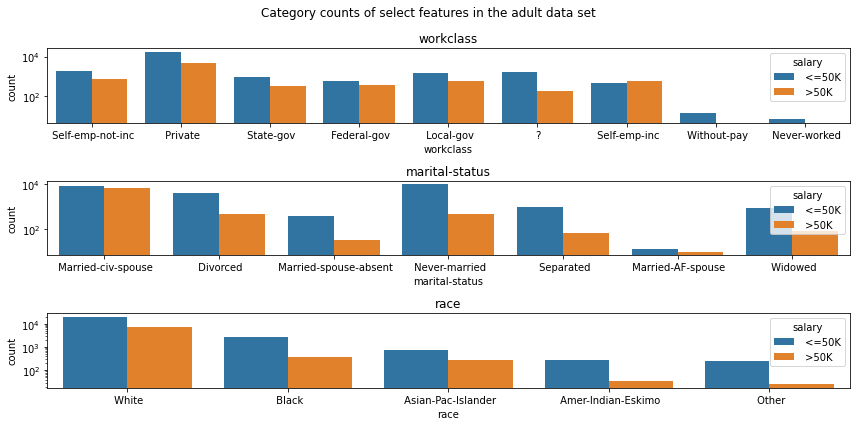

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=((12, 6)))
fig.suptitle('Category counts of select features in the adult data set')
sns.countplot(x='workclass', hue='salary', data=df, ax=ax[0])
ax[0].set(yscale='log')
ax[0].set_title('workclass')
sns.countplot(x='marital-status', hue='salary', data=df, ax=ax[1])
ax[1].set(yscale='log')
ax[1].set_title('marital-status')
sns.countplot(x='race', hue='salary', data=df, ax=ax[2])
ax[2].set(yscale='log')
ax[2].set_title('race')
fig.tight_layout()

pngFile = './figures/CH08_F13_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

In [7]:
X, y = df.drop('salary', axis=1), df['salary']  # Split the data into features and targets

from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

from sklearn.model_selection import train_test_split
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.2)

features = X.columns
cat_features = ['workclass', 'education', 'marital-status', 'occupation', 
                'relationship', 'race', 'sex', 'native-country']
cont_features = features.drop(cat_features).tolist()

In [9]:
import numpy as np
n_pos, n_neg = np.sum(y > 0)/len(y), np.sum(y <= 0)/len(y)
print(n_pos, n_neg)

0.24081695331695332 0.7591830466830467


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import category_encoders as ce
            
def create_preprocessor(encoder):
    preprocess_continuous = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='median')),
                                            ('normalize', StandardScaler())])
    preprocess_categorical = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='constant', fill_value='missing')),
                                             ('encode', encoder())])
    transformations = ColumnTransformer(transformers=[('continuous', preprocess_continuous, cont_features),
                                                      ('categorical', preprocess_categorical, cat_features)])
    
    return transformations

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score

def train_and_evaluate_models(ensemble, parameters, n_iter=25, cv=5):
    results = pd.DataFrame()
    
    for encoder in [ce.OneHotEncoder, ce.OrdinalEncoder, ce.TargetEncoder]:
        preprocess_pipeline = create_preprocessor(encoder)
        print('Encoder = {0}, Ensemble = {1}'.format(encoder, type(ensemble)))

        model = Pipeline(steps=[('preprocess', preprocess_pipeline),
                                ('crossvalidate', RandomizedSearchCV(ensemble, parameters, 
                                                                     n_iter=n_iter, cv=cv, 
                                                                     refit=True, verbose=2))])
        model.fit(Xtrn, ytrn)
        
        ypred_trn = model.predict(Xtrn)
        ypred_tst = model.predict(Xtst)    

        res = {'Encoder': encoder.__name__,
               'Ensemble': ensemble.__class__.__name__, 
               'Train Acc': accuracy_score(ytrn, ypred_trn),
               'Train B Acc': balanced_accuracy_score(ytrn, ypred_trn), 
               'Train F1': f1_score(ytrn, ypred_trn), 
               'Test Acc': accuracy_score(ytst, ypred_tst),
               'Test B Acc': balanced_accuracy_score(ytst, ypred_tst),
               'Test F1': f1_score(ytst, ypred_tst)}
        results = results.append(res, ignore_index=True)
    
    return results

### Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

ensemble = RandomForestClassifier(n_jobs=-1)
parameters = {'n_estimators': [25, 50, 100, 200],
              'max_depth': [3, 5, 7, 10],
              'max_features': [0.2, 0.4, 0.6, 0.8]}

rf_results = train_and_evaluate_models(ensemble, parameters, n_iter=25, cv=5)

Encoder = <class 'category_encoders.one_hot.OneHotEncoder'>, Ensemble = <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ....max_depth=3, max_features=0.8, n_estimators=100; total time=   4.9s
[CV] END ....max_depth=3, max_features=0.8, n_estimators=100; total time=   1.2s
[CV] END ....max_depth=3, max_features=0.8, n_estimators=100; total time=   1.2s
[CV] END ....max_depth=3, max_features=0.8, n_estimators=100; total time=   1.2s
[CV] END ....max_depth=3, max_features=0.8, n_estimators=100; total time=   1.2s
[CV] END .....max_depth=5, max_features=0.4, n_estimators=25; total time=   0.4s
[CV] END .....max_depth=5, max_features=0.4, n_estimators=25; total time=   0.4s
[CV] END .....max_depth=5, max_features=0.4, n_estimators=25; total time=   0.4s
[CV] END .....max_depth=5, max_features=0.4, n_estimators=25; total time=   0.4s
[CV] END .....max_depth=5, max_features=0.4, n_estimators=25; total time=   0.4

[CV] END ....max_depth=7, max_features=0.8, n_estimators=200; total time=   3.4s
[CV] END ....max_depth=10, max_features=0.6, n_estimators=50; total time=   1.0s
[CV] END ....max_depth=10, max_features=0.6, n_estimators=50; total time=   0.9s
[CV] END ....max_depth=10, max_features=0.6, n_estimators=50; total time=   1.1s
[CV] END ....max_depth=10, max_features=0.6, n_estimators=50; total time=   0.9s
[CV] END ....max_depth=10, max_features=0.6, n_estimators=50; total time=   0.9s
[CV] END ....max_depth=7, max_features=0.4, n_estimators=200; total time=   2.5s
[CV] END ....max_depth=7, max_features=0.4, n_estimators=200; total time=   2.1s
[CV] END ....max_depth=7, max_features=0.4, n_estimators=200; total time=   2.0s
[CV] END ....max_depth=7, max_features=0.4, n_estimators=200; total time=   2.1s
[CV] END ....max_depth=7, max_features=0.4, n_estimators=200; total time=   2.1s
[CV] END ....max_depth=3, max_features=0.4, n_estimators=100; total time=   0.8s
[CV] END ....max_depth=3, ma

[CV] END ....max_depth=10, max_features=0.4, n_estimators=50; total time=   0.3s
[CV] END ....max_depth=10, max_features=0.4, n_estimators=50; total time=   0.3s
[CV] END ....max_depth=3, max_features=0.6, n_estimators=100; total time=   0.5s
[CV] END ....max_depth=3, max_features=0.6, n_estimators=100; total time=   0.4s
[CV] END ....max_depth=3, max_features=0.6, n_estimators=100; total time=   0.4s
[CV] END ....max_depth=3, max_features=0.6, n_estimators=100; total time=   0.6s
[CV] END ....max_depth=3, max_features=0.6, n_estimators=100; total time=   0.5s
[CV] END ....max_depth=5, max_features=0.2, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=5, max_features=0.2, n_estimators=200; total time=   0.8s
[CV] END ....max_depth=5, max_features=0.2, n_estimators=200; total time=   0.6s
[CV] END ....max_depth=5, max_features=0.2, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=5, max_features=0.2, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=3, ma

[CV] END .....max_depth=3, max_features=0.2, n_estimators=25; total time=   0.3s
[CV] END .....max_depth=3, max_features=0.2, n_estimators=25; total time=   0.2s
[CV] END .....max_depth=3, max_features=0.2, n_estimators=25; total time=   0.3s
[CV] END .....max_depth=7, max_features=0.4, n_estimators=50; total time=   0.3s
[CV] END .....max_depth=7, max_features=0.4, n_estimators=50; total time=   0.3s
[CV] END .....max_depth=7, max_features=0.4, n_estimators=50; total time=   0.3s
[CV] END .....max_depth=7, max_features=0.4, n_estimators=50; total time=   0.3s
[CV] END .....max_depth=7, max_features=0.4, n_estimators=50; total time=   0.3s
[CV] END ....max_depth=5, max_features=0.4, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=5, max_features=0.4, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=5, max_features=0.4, n_estimators=200; total time=   0.8s
[CV] END ....max_depth=5, max_features=0.4, n_estimators=200; total time=   0.7s
[CV] END ....max_depth=5, ma

In [9]:
rf_results

,Encoder,Ensemble,Test Acc,Test B Acc,Test F1,Train Acc,Train B Acc,Train F1
0,OneHotEncoder,RandomForestClassifier,0.862254,0.765531,0.669126,0.875230,0.783137,0.700406
1,OrdinalEncoder,RandomForestClassifier,0.860719,0.756011,0.656829,0.873580,0.773020,0.688133
2,TargetEncoder,RandomForestClassifier,0.863790,0.773743,0.679436,0.881104,0.797395,0.720412


### LightGBM

In [10]:
from lightgbm import LGBMClassifier

ensemble = LGBMClassifier(n_estimators=200, n_jobs=-1)
parameters = {'max_depth': np.arange(3, 10, step=1), 
              'learning_rate': 2**np.arange(-8., 2., step=2),
              'bagging_fraction': [0.4, 0.5, 0.6, 0.7, 0.8],
              'lambda_l1': [0, 0.01, 0.1, 1, 10],
              'lambda_l2': [0, 0.01, 0.1, 1e-1, 1, 10]}

lgbm_results = train_and_evaluate_models(ensemble, parameters, n_iter=50, cv=5)

Encoder = <class 'category_encoders.one_hot.OneHotEncoder'>, Ensemble = <class 'lightgbm.sklearn.LGBMClassifier'>
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0, learning_rate=0.0625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0, learning_rate=0.0625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0, learning_rate=0.0625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0, learning_rate=0.0625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0, learning_rate=0.0625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.5, lambda_l1=0.01, lambda_l2=0.01, learning_rate=0.015625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.5, lambda_l1=0.01, lambda_l2=0.01, learning_rate=0.015625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=

[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0.1, learning_rate=0.0625, max_depth=9; total time=   0.4s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0.1, learning_rate=0.0625, max_depth=9; total time=   0.4s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0.1, learning_rate=0.0625, max_depth=9; total time=   0.4s
[CV] END bagging_fraction=0.5, lambda_l1=1, lambda_l2=0.1, learning_rate=0.0625, max_depth=9; total time=   0.4s
[CV] END bagging_fraction=0.8, lambda_l1=0.1, lambda_l2=10, learning_rate=0.25, max_depth=9; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=0.1, lambda_l2=10, learning_rate=0.25, max_depth=9; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=0.1, lambda_l2=10, learning_rate=0.25, max_depth=9; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=0.1, lambda_l2=10, learning_rate=0.25, max_depth=9; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=0.1, lambda_l2=10, learning_rate=0.25, max_depth=9; total t

[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=0.01, learning_rate=0.00390625, max_depth=7; total time=   0.4s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=0.01, learning_rate=0.00390625, max_depth=7; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=10, learning_rate=0.015625, max_depth=9; total time=   0.4s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=10, learning_rate=0.015625, max_depth=9; total time=   0.4s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=10, learning_rate=0.015625, max_depth=9; total time=   0.4s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=10, learning_rate=0.015625, max_depth=9; total time=   0.4s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=10, learning_rate=0.015625, max_depth=9; total time=   0.4s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0.1, learning_rate=1.0, max_depth=5; total time=   0.3s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0.1, learning_rate=1.0,

[CV] END bagging_fraction=0.7, lambda_l1=0.1, lambda_l2=0.1, learning_rate=1.0, max_depth=5; total time=   0.3s
[CV] END bagging_fraction=0.7, lambda_l1=0.1, lambda_l2=0.1, learning_rate=1.0, max_depth=5; total time=   0.3s
[CV] END bagging_fraction=0.7, lambda_l1=0.1, lambda_l2=0.1, learning_rate=1.0, max_depth=5; total time=   0.3s
[CV] END bagging_fraction=0.7, lambda_l1=0.1, lambda_l2=0.1, learning_rate=1.0, max_depth=5; total time=   0.3s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0, learning_rate=0.015625, max_depth=3; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0, learning_rate=0.015625, max_depth=3; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0, learning_rate=0.015625, max_depth=3; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0, learning_rate=0.015625, max_depth=3; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0, learning_rate=0.015625, max_depth=3; total 

[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=0.1, learning_rate=0.015625, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=0.1, learning_rate=0.015625, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=0.1, learning_rate=0.015625, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=0.1, learning_rate=0.015625, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=0, learning_rate=0.25, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=0, learning_rate=0.25, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=0, learning_rate=0.25, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=0, learning_rate=0.25, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.7, lambda_l1=0, lambda_l2=0, learning_rate=0.25, max_depth=4; total time

[CV] END bagging_fraction=0.7, lambda_l1=0.01, lambda_l2=0, learning_rate=0.015625, max_depth=7; total time=   0.3s
[CV] END bagging_fraction=0.7, lambda_l1=0.01, lambda_l2=0, learning_rate=0.015625, max_depth=7; total time=   0.4s
[CV] END bagging_fraction=0.8, lambda_l1=0.1, lambda_l2=1, learning_rate=1.0, max_depth=7; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=0.1, lambda_l2=1, learning_rate=1.0, max_depth=7; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=0.1, lambda_l2=1, learning_rate=1.0, max_depth=7; total time=   0.2s
[CV] END bagging_fraction=0.8, lambda_l1=0.1, lambda_l2=1, learning_rate=1.0, max_depth=7; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=0.1, lambda_l2=1, learning_rate=1.0, max_depth=7; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=0.01, learning_rate=1.0, max_depth=6; total time=   0.1s
[CV] END bagging_fraction=0.8, lambda_l1=10, lambda_l2=0.01, learning_rate=1.0, max_depth=6; total time=  

[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=0, learning_rate=0.00390625, max_depth=9; total time=   0.3s
[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=0, learning_rate=0.00390625, max_depth=9; total time=   0.3s
[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=0, learning_rate=0.00390625, max_depth=9; total time=   0.3s
[CV] END bagging_fraction=0.7, lambda_l1=10, lambda_l2=0, learning_rate=0.00390625, max_depth=9; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=1, lambda_l2=10, learning_rate=0.015625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.8, lambda_l1=1, lambda_l2=10, learning_rate=0.015625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.8, lambda_l1=1, lambda_l2=10, learning_rate=0.015625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.8, lambda_l1=1, lambda_l2=10, learning_rate=0.015625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.8, lambda_l1=1, lambda_l2=10, learning_rate=0.015625

[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0.01, learning_rate=0.015625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0.01, learning_rate=0.015625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0.01, learning_rate=0.015625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.6, lambda_l1=1, lambda_l2=0.1, learning_rate=0.015625, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.6, lambda_l1=1, lambda_l2=0.1, learning_rate=0.015625, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.6, lambda_l1=1, lambda_l2=0.1, learning_rate=0.015625, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.6, lambda_l1=1, lambda_l2=0.1, learning_rate=0.015625, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.6, lambda_l1=1, lambda_l2=0.1, learning_rate=0.015625, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=0, lambda_l2=0, learning_rate=0.2

[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0.1, learning_rate=0.015625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0.1, learning_rate=0.015625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0.1, learning_rate=0.015625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0.1, learning_rate=0.015625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.5, lambda_l1=10, lambda_l2=0.1, learning_rate=0.015625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0.01, learning_rate=0.25, max_depth=5; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0.01, learning_rate=0.25, max_depth=5; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0.01, learning_rate=0.25, max_depth=5; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=0.1, lambda_l2=0.01, learning_rate=0.

[CV] END bagging_fraction=0.6, lambda_l1=0.1, lambda_l2=0, learning_rate=0.00390625, max_depth=3; total time=   0.1s
[CV] END bagging_fraction=0.4, lambda_l1=0.01, lambda_l2=1, learning_rate=0.015625, max_depth=5; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=0.01, lambda_l2=1, learning_rate=0.015625, max_depth=5; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=0.01, lambda_l2=1, learning_rate=0.015625, max_depth=5; total time=   0.2s
[CV] END bagging_fraction=0.4, lambda_l1=0.01, lambda_l2=1, learning_rate=0.015625, max_depth=5; total time=   0.3s
[CV] END bagging_fraction=0.4, lambda_l1=0.01, lambda_l2=1, learning_rate=0.015625, max_depth=5; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=0.01, learning_rate=1.0, max_depth=8; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=0.01, learning_rate=1.0, max_depth=8; total time=   0.3s
[CV] END bagging_fraction=0.8, lambda_l1=0, lambda_l2=0.01, learning_rate=1.0, ma

[CV] END bagging_fraction=0.6, lambda_l1=0, lambda_l2=0.1, learning_rate=0.25, max_depth=7; total time=   0.3s
[CV] END bagging_fraction=0.6, lambda_l1=0, lambda_l2=0.1, learning_rate=0.25, max_depth=7; total time=   0.3s
[CV] END bagging_fraction=0.6, lambda_l1=0, lambda_l2=0.1, learning_rate=0.25, max_depth=7; total time=   0.3s
[CV] END bagging_fraction=0.6, lambda_l1=0, lambda_l2=0.1, learning_rate=0.25, max_depth=7; total time=   0.2s
[CV] END bagging_fraction=0.6, lambda_l1=0.1, lambda_l2=0, learning_rate=0.00390625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.6, lambda_l1=0.1, lambda_l2=0, learning_rate=0.00390625, max_depth=4; total time=   0.1s
[CV] END bagging_fraction=0.6, lambda_l1=0.1, lambda_l2=0, learning_rate=0.00390625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.6, lambda_l1=0.1, lambda_l2=0, learning_rate=0.00390625, max_depth=4; total time=   0.2s
[CV] END bagging_fraction=0.6, lambda_l1=0.1, lambda_l2=0, learning_rate=0.00390625, max

In [11]:
lgbm_results

,Encoder,Ensemble,Test Acc,Test B Acc,Test F1,Train Acc,Train B Acc,Train F1
0,OneHotEncoder,LGBMClassifier,0.873618,0.801814,0.716305,0.890779,0.824165,0.754212
1,OrdinalEncoder,LGBMClassifier,0.874386,0.802101,0.717346,0.892429,0.824872,0.756729
2,TargetEncoder,LGBMClassifier,0.872850,0.796290,0.710490,0.885903,0.814535,0.740799


### XGBoost

In [18]:
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

ensemble = XGBClassifier(eval_metric='logloss', n_estimators=200, n_jobs=-1)
parameters = {'max_depth': np.arange(3, 10, step=1), 
              'learning_rate': 2**np.arange(-8., 2., step=2),
              'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8],
              'reg_alpha': [0, 0.01, 0.1, 1, 10],
              'reg_lambda': [0, 0.01, 0.1, 1e-1, 1, 10]}

xgb_results = train_and_evaluate_models(ensemble, parameters, n_iter=50, cv=5)

Encoder = <class 'category_encoders.one_hot.OneHotEncoder'>, Ensemble = <class 'xgboost.sklearn.XGBClassifier'>
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=7, reg_alpha=1, reg_lambda=0; total time=   2.0s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=7, reg_alpha=1, reg_lambda=0; total time=   1.9s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=7, reg_alpha=1, reg_lambda=0; total time=   1.9s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=7, reg_alpha=1, reg_lambda=0; total time=   1.9s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=7, reg_alpha=1, reg_lambda=0; total time=   2.0s
[CV] END colsample_bytree=0.7, learning_rate=0.0625, max_depth=7, reg_alpha=10, reg_lambda=0.1; total time=   2.2s
[CV] END colsample_bytree=0.7, learning_rate=0.0625, max_depth=7, reg_alpha=10, reg_lambda=0.1; total time=   2.3s
[CV] END colsample_bytree=0.7, learning_rate=0.0625

[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=9, reg_alpha=0, reg_lambda=1; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=9, reg_alpha=0, reg_lambda=1; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=9, reg_alpha=0, reg_lambda=1; total time=   3.4s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=9, reg_alpha=0, reg_lambda=1; total time=   3.3s
[CV] END colsample_bytree=0.8, learning_rate=1.0, max_depth=9, reg_alpha=0, reg_lambda=1; total time=   3.3s
[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   1.6s
[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=4, reg_alpha=1, reg_lambda=0.1; total time=   1.4s
[CV] END co

[CV] END colsample_bytree=0.7, learning_rate=0.0625, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.0625, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.0625, max_depth=3, reg_alpha=0.1, reg_lambda=0.1; total time=   1.1s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.01, reg_lambda=10; total time=   1.4s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.01, reg_lambda=10; total time=   1.5s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.01, reg_lambda=10; total time=   1.5s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.01, reg_lambda=10; total time=   1.4s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.01, reg_lambda=10; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.25, max_depth=9, reg_alpha=1, reg_l

[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=3, reg_alpha=10, reg_lambda=1; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=6, reg_alpha=0, reg_lambda=0; total time=   1.9s
[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=6, reg_alpha=0, reg_lambda=0; total time=   2.0s
[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=6, reg_alpha=0, reg_lambda=0; total time=   1.9s
[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=6, reg_alpha=0, reg_lambda=0; total time=   2.0s
[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=6, reg_alpha=0, reg_lambda=0; total time=   2.0s
[CV] END colsample_bytree=0.5, learning_rate=0.0625, max_depth=9, reg_alpha=10, reg_lambda=1; total time=   2.7s
[CV] END colsample_bytree=0.5, learning_rate=0.0625, max_depth=9, reg_alpha=10, reg_lambda=1; total time=   2.6s
[CV] END colsample_bytree=0.5, learning_rate=0.0625, max_depth=9, reg_alpha=10, reg_lambda=1; total time=   2.6s

[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=4, reg_alpha=0, reg_lambda=0.01; total time=   0.8s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=4, reg_alpha=0, reg_lambda=0.01; total time=   0.9s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=4, reg_alpha=0, reg_lambda=0.01; total time=   0.8s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=4, reg_alpha=0, reg_lambda=0.01; total time=   0.8s
[CV] END colsample_bytree=0.4, learning_rate=0.00390625, max_depth=4, reg_alpha=0, reg_lambda=0.01; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.015625, max_depth=3, reg_alpha=10, reg_lambda=0.1; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.015625, max_depth=3, reg_alpha=10, reg_lambda=0.1; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.015625, max_depth=3, reg_alpha=10, reg_lambda=0.1; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.015625,

[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=6, reg_alpha=0.01, reg_lambda=0.01; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=6, reg_alpha=0.01, reg_lambda=0.01; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=6, reg_alpha=0.01, reg_lambda=0.01; total time=   1.5s
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_depth=5, reg_alpha=0, reg_lambda=10; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_depth=5, reg_alpha=0, reg_lambda=10; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_depth=5, reg_alpha=0, reg_lambda=10; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_depth=5, reg_alpha=0, reg_lambda=10; total time=   1.1s
[CV] END colsample_bytree=0.5, learning_rate=0.00390625, max_depth=5, reg_alpha=0, reg_lambda=10; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=4, reg_

[CV] END colsample_bytree=0.5, learning_rate=0.015625, max_depth=9, reg_alpha=10, reg_lambda=0.1; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=9, reg_alpha=10, reg_lambda=1; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=9, reg_alpha=10, reg_lambda=1; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=9, reg_alpha=10, reg_lambda=1; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=9, reg_alpha=10, reg_lambda=1; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.0625, max_depth=9, reg_alpha=10, reg_lambda=1; total time=   2.5s
[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=7, reg_alpha=10, reg_lambda=10; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=7, reg_alpha=10, reg_lambda=10; total time=   0.9s
[CV] END colsample_bytree=0.7, learning_rate=0.25, max_depth=7, reg_alpha=10, reg_lambda=10; t

[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.1, reg_lambda=1; total time=   1.0s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.1, reg_lambda=1; total time=   1.0s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.1, reg_lambda=1; total time=   0.9s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.1, reg_lambda=1; total time=   1.0s
[CV] END colsample_bytree=0.4, learning_rate=0.25, max_depth=5, reg_alpha=0.1, reg_lambda=1; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.015625, max_depth=7, reg_alpha=0.1, reg_lambda=10; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.015625, max_depth=7, reg_alpha=0.1, reg_lambda=10; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.015625, max_depth=7, reg_alpha=0.1, reg_lambda=10; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.015625, max_depth=7, reg_alpha=0.1, reg_la

[CV] END colsample_bytree=0.7, learning_rate=1.0, max_depth=7, reg_alpha=1, reg_lambda=0.01; total time=   1.8s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=5, reg_alpha=10, reg_lambda=0; total time=   0.5s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=5, reg_alpha=10, reg_lambda=0; total time=   0.4s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=5, reg_alpha=10, reg_lambda=0; total time=   0.5s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=5, reg_alpha=10, reg_lambda=0; total time=   0.5s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=5, reg_alpha=10, reg_lambda=0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.00390625, max_depth=4, reg_alpha=1, reg_lambda=0; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.00390625, max_depth=4, reg_alpha=1, reg_lambda=0; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.00390625, max_depth=4, reg_alpha=1, reg_lambda=0; total tim

[CV] END colsample_bytree=0.7, learning_rate=0.015625, max_depth=4, reg_alpha=0.1, reg_lambda=0.1; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.015625, max_depth=4, reg_alpha=0.1, reg_lambda=0.1; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.015625, max_depth=4, reg_alpha=0.1, reg_lambda=0.1; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.015625, max_depth=4, reg_alpha=0.1, reg_lambda=0.1; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.0625, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   1.3s
[CV] END colsample_bytree=0.5, learning_rate=0.0625, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   1.3s
[CV] END colsample_bytree=0.5, learning_rate=0.0625, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   1.3s
[CV] END colsample_bytree=0.5, learning_rate=0.0625, max_depth=6, reg_alpha=10, reg_lambda=0.1; total time=   1.3s
[CV] END colsample_bytree=0.5, learning_rate=0.0625, max_depth=6, re

[CV] END colsample_bytree=0.8, learning_rate=0.015625, max_depth=8, reg_alpha=0, reg_lambda=0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.015625, max_depth=8, reg_alpha=0, reg_lambda=0; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.00390625, max_depth=9, reg_alpha=10, reg_lambda=0.1; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.00390625, max_depth=9, reg_alpha=10, reg_lambda=0.1; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.00390625, max_depth=9, reg_alpha=10, reg_lambda=0.1; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.00390625, max_depth=9, reg_alpha=10, reg_lambda=0.1; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.00390625, max_depth=9, reg_alpha=10, reg_lambda=0.1; total time=   2.3s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=6, reg_alpha=1, reg_lambda=1; total time=   1.2s
[CV] END colsample_bytree=0.4, learning_rate=1.0, max_depth=6, reg_a

In [19]:
xgb_results

,Encoder,Ensemble,Test Acc,Test B Acc,Test F1,Train Acc,Train B Acc,Train F1
0,OneHotEncoder,XGBClassifier,0.874693,0.799467,0.715283,0.895501,0.829288,0.763838
1,OrdinalEncoder,XGBClassifier,0.872697,0.798589,0.712452,0.890625,0.822759,0.752927
2,TargetEncoder,XGBClassifier,0.874693,0.801649,0.717256,0.898265,0.833992,0.770761


In [21]:
from catboost import CatBoostClassifier

ensemble = CatBoostClassifier(cat_features=cat_features)
parameters = {'iterations': [25, 50, 100, 200],
              'depth': np.arange(3, 10, step=1), 
              'learning_rate': 2**np.arange(-5., 0., step=1),
              'l2_leaf_reg': [0, 0.01, 0.1, 1e-1, 1, 10]}

search = ensemble.randomized_search(parameters, Xtrn, ytrn, n_iter=50, cv=5, refit=True, verbose=False)
ypred_trn = ensemble.predict(Xtrn)
ypred_tst = ensemble.predict(Xtst)    

res = {'Encoder': '',
       'Ensemble': ensemble.__class__.__name__, 
       'Train Acc': accuracy_score(ytrn, ypred_trn),
       'Train B Acc': balanced_accuracy_score(ytrn, ypred_trn), 
       'Train F1': f1_score(ytrn, ypred_trn), 
       'Test Acc': accuracy_score(ytst, ypred_tst),
       'Test B Acc': balanced_accuracy_score(ytst, ypred_tst),
       'Test F1': f1_score(ytst, ypred_tst)}
cat_results = pd.DataFrame()
cat_results = cat_results.append(res, ignore_index=True)


bestTest = 0.2995466491
bestIteration = 24


bestTest = 0.3437601889
bestIteration = 49


bestTest = 0.2911032945
bestIteration = 98


bestTest = 0.2851349714
bestIteration = 198


bestTest = 0.3300774786
bestIteration = 24


bestTest = 0.2947221034
bestIteration = 24


bestTest = 0.3317749398
bestIteration = 24


bestTest = 0.3817690476
bestIteration = 24


bestTest = 0.3100562501
bestIteration = 49


bestTest = 0.3099597816
bestIteration = 49


bestTest = 0.2787446767
bestIteration = 49


bestTest = 0.2773575663
bestIteration = 95


bestTest = 0.2773084941
bestIteration = 95


bestTest = 0.2810458017
bestIteration = 99


bestTest = 0.2953928063
bestIteration = 199


bestTest = 0.2896308364
bestIteration = 23


bestTest = 0.3042007187
bestIteration = 24


bestTest = 0.3028705463
bestIteration = 49


bestTest = 0.3033063176
bestIteration = 99


bestTest = 0.2782502024
bestIteration = 65


bestTest = 0.281173707
bestIteration = 96


bestTest = 0.2910353952
bestIteration = 199


bestTes

In [22]:
cat_results

,Encoder,Ensemble,Test Acc,Test B Acc,Test F1,Train Acc,Train B Acc,Train F1
0,,CatBoostClassifier,0.870086,0.796216,0.707671,0.887976,0.819709,0.747403


In [23]:
results = pd.concat([rf_results, lgbm_results, xgb_results, cat_results])
results.to_csv('./data/ch08/case-study-results.csv', index=False)

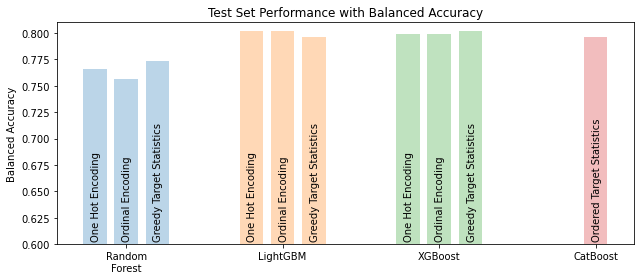

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
results = pd.read_csv('./data/ch08/case-study-results.csv')
results

# groups = {'RandomForestClassifier': ['OneHotEncoder', 'OrdinalEncoder', 'TargetEncoder'],
#           'LGBMClassifier': ['OneHotEncoder', 'OrdinalEncoder', 'TargetEncoder'],
#           'XGBClassifier': ['OneHotEncoder', 'OrdinalEncoder', 'TargetEncoder'],
#           'CatBoostClassifier': []}

groups = {'Random\nForest': [0, 1, 2], 
          'LightGBM': [3, 4, 5], 
          'XGBoost': [6, 7, 8], 
          'CatBoost': 9}    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
for j, metric in enumerate(['Test B Acc']):
    for i, (methods, group) in enumerate(groups.items()):
        k = results.columns.get_loc(metric)
        yy = results.values[groups[methods], k]
        
        if methods == 'CatBoost':
            xx = i + (np.arange(0, 1) - np.median(np.arange(0, 1))) * 0.2
        else:
            xx = i + (np.arange(0, len(yy)) - np.median(np.arange(0, len(yy)))) * 0.2
        ax.bar(xx, yy, width=0.15, alpha=0.3)
#         
        encs = ['One Hot Encoding', 'Ordinal Encoding', 'Greedy Target Statistics']
        for t in range(len(xx)):
            if len(xx) == 1:
                ax.text(xx[t]-0.025, 0.605, 'Ordered Target Statistics', rotation='vertical')
            else:
                ax.text(xx[t]-0.025, 0.605, encs[t], rotation='vertical')
ax.set_xticks(range(4))
ax.set_xticklabels(list(groups.keys()))
ax.set_ylabel('Balanced Accuracy');
ax.set_title('Test Set Performance with Balanced Accuracy');
ax.set_ylim(0.6, 0.81)

fig.tight_layout()
pngFile = './figures/CH08_F14_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0.05)

In [16]:
import pandas as pd
results = pd.read_csv('./data/ch08/case-study-results.csv')

In [17]:
results = results.drop('Encoder', axis=1)
pd.options.display.float_format = '{:,.3}'.format
print(results.to_string(index=False))

               Ensemble  Test Acc  Test B Acc  Test F1  Train Acc  Train B Acc  Train F1
 RandomForestClassifier     0.862       0.766    0.669      0.875        0.783       0.7
 RandomForestClassifier     0.861       0.756    0.657      0.874        0.773     0.688
 RandomForestClassifier     0.864       0.774    0.679      0.881        0.797      0.72
         LGBMClassifier     0.874       0.802    0.716      0.891        0.824     0.754
         LGBMClassifier     0.874       0.802    0.717      0.892        0.825     0.757
         LGBMClassifier     0.873       0.796     0.71      0.886        0.815     0.741
          XGBClassifier     0.875       0.799    0.715      0.896        0.829     0.764
          XGBClassifier     0.873       0.799    0.712      0.891        0.823     0.753
          XGBClassifier     0.875       0.802    0.717      0.898        0.834     0.771
     CatBoostClassifier      0.87       0.796    0.708      0.888         0.82     0.747
